In [ ]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.special import lambertw
import pandas as pd
import os
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z


In [ ]:
def ConstructHists(E_reco,Nbins=50):
    mean = np.mean(E_reco)
    rms = np.std(E_reco)
    mask = (E_reco >= mean - 5*rms) & (E_reco <= mean + 5*rms)
    filtered_data = E_reco[mask]
    counts, bin_edges = np.histogram(filtered_data, bins=Nbins)
    return counts, bin_edges
# 打开 ROOT 文件，载入 events tree
Si=0.75
SamplingLayer=30
ECAL_layers=60
DataPath=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
ParticleEnergy=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
Threshold_i=0.3
Threshold=Threshold_i*0.2282
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
E_sum_list = []
N_hits_list = []
E_true_list = []
for i_E in range(len(ParticleEnergy)):
    input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    Event_energy = ak.sum(energy, axis=1) * 1000
    Number_hits  = ak.num(energy, axis=1)
    E_sum_list.append(Event_energy)
    N_hits_list.append(Number_hits)
    E_true_list.append([ParticleEnergy[i_E]]*len(Event_energy))

E_sum = ak.to_numpy(ak.concatenate(E_sum_list))
N_hits = ak.to_numpy(ak.concatenate(N_hits_list))
E_true = ak.to_numpy(ak.concatenate(E_true_list))
hist_E = []
for i_E in range(len(ParticleEnergy)):
    #Sum of E
    mask = E_true == ParticleEnergy[i_E]
    counts, bin_edges = ConstructHists((E_sum[mask]),Nbins=50)
    hist = {
        'counts': counts,
        'bin_edges': bin_edges,
        'Energy': ParticleEnergy[i_E]
        }
    hist_E.append(hist)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/0.1GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_la

In [41]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(E, type, bin_edges, counts):    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')
    if type == "E":
        plt.title(f"Deposited Energy {E} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = max(bin_edges[0], mean - k*theta) # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1, mu*0.1-100, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]


    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / mean_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * mean_gamma - np.sqrt(k) * theta * (theta)) / (mean_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (mean_gamma**2)
    dr_dtheta = (np.sqrt(k) * mean_gamma - np.sqrt(k) * theta * (k - 1.0)) / (mean_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")

    #Gaussian Fit
    params_gauss_initial = np.array([max(counts), res_gamma, peak_gamma])
    lower_bounds = 0.5 * params_gauss_initial
    upper_bounds = 100 * params_gauss_initial
    print(f"Initial Gaussian Fit Parameters: {params_gauss_initial}")
    params_gauss, cov_gauss = curve_fit(fit_gaussian, bin_centers, counts, p0=params_gauss_initial, bounds=(lower_bounds, upper_bounds))
    peak_gauss = peak_gamma
    sigma_gauss = res_gamma * peak_gamma
    fit_mask = (bin_centers >= peak_gauss - 2 * sigma_gauss) & (bin_centers <= peak_gauss + 2 * sigma_gauss)
    x_fit = bin_centers[fit_mask]
    y_fit = counts[fit_mask]
    params_gauss, cov_gauss = curve_fit(fit_gaussian, x_fit, y_fit, p0=params_gauss_initial)
    x_fit_gauss = x_fit
    y_fit_gauss = fit_gaussian(x_fit, *params_gauss)
    peak_gauss = params_gauss[2]
    peak_gauss_error = np.sqrt(cov_gauss[2, 2])
    mean_gauss = peak_gauss
    mean_gauss_error = peak_gauss_error
    res_gauss = params_gauss[1]
    res_gauss_error = np.sqrt(cov_gauss[1, 1])
    print(f"Gaussian Fit Peak: {peak_gauss} ± {peak_gauss_error}, Resolution: {res_gauss} ± {res_gauss_error}")

    #Log Normal Fit
    var = rms**2
    sigma = np.sqrt(np.log(var/(mean**2)+1))
    scale = np.sqrt( var / ( np.exp(sigma**2) * (np.exp(sigma**2) - 1)) )
    loc = max(peak - scale*np.exp(-sigma**2), 0.1)
    params_log_normal_initial = np.array([max(counts), sigma, loc, scale])
    lower_bounds = 0.001 * params_log_normal_initial
    upper_bounds = 1000 * params_log_normal_initial
    print(f"Initial Log Normal Fit Parameters: {params_log_normal_initial}")
    params_log_normal, cov_log_normal = curve_fit(fit_log_normal, bin_centers, counts, p0=params_log_normal_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Log Normal Fit Parameters: {params_log_normal}")
    x_fit_log_normal = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_log_normal = fit_log_normal(x_fit_log_normal, *params_log_normal)
    sigma, loc, scale = params_log_normal[1], params_log_normal[2], params_log_normal[3]
    peak_log_normal=loc + scale * np.exp(-sigma**2)
    mean_log_normal = loc + scale * np.exp(sigma**2 / 2)
    var = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2)
    res_log_normal = np.sqrt(var) / mean_log_normal    
    # ---- error propagation ----
    # partial derivatives for peak
    d_peak_d_sigma = -2 * sigma * scale * np.exp(-sigma**2)
    d_peak_d_loc = 1.0
    d_peak_d_scale = np.exp(-sigma**2)    
    # partial derivatives for variance
    d_var_d_sigma = (2*sigma*np.exp(sigma**2) * np.exp(2*np.log(scale) + sigma**2)
                     + (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * 2*sigma)
    d_var_d_scale = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * (2/scale)
    # derivatives for resolution
    d_res_d_sigma = (0.5 / np.sqrt(var) * d_var_d_sigma * peak - np.sqrt(var) * d_peak_d_sigma) / (peak**2)
    d_res_d_loc = -np.sqrt(var) * d_peak_d_loc / (peak**2)
    d_res_d_scale = (0.5 / np.sqrt(var) * d_var_d_scale * peak - np.sqrt(var) * d_peak_d_scale) / (peak**2)
    # errors
    peak_grad = np.array([0, d_peak_d_sigma, d_peak_d_loc, d_peak_d_scale])
    mean_grad = np.array([0, d_peak_d_sigma/2, d_peak_d_loc, d_peak_d_scale])  
    res_grad  = np.array([0, d_res_d_sigma, d_res_d_loc, d_res_d_scale])    
    peak_log_normal_error = np.sqrt(peak_grad @ cov_log_normal @ peak_grad)
    mean_log_normal_error = np.sqrt(mean_grad @ cov_log_normal @ mean_grad)
    res_log_normal_error  = np.sqrt(res_grad @ cov_log_normal @ res_grad)
    print(f"Log Normal Fit Peak: {peak_log_normal} ± {peak_log_normal_error}, Resolution: {res_log_normal} ± {res_log_normal_error}")

    plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")
    plt.plot(x_fit_gamma, y_fit_gamma, 'g-', label="Gamma Fit")
    plt.plot(x_fit_log_normal, y_fit_log_normal, 'm-', label="Log Normal Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()
    return (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
            mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
            mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error)



<>:130: SyntaxWarning: invalid escape sequence '\s'
<>:130: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_519728/3193394689.py:130: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")


In [42]:
# #This cell is left here for debug
# hist = hist_E[9]
# (mean_gauss,mean_gauss_error,peak_gauss,peak_gauss_error,res_gauss,res_gauss_error,
#  mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error,
#  mean_log_normal,mean_log_normal_error,peak_log_normal,peak_log_normal_error,res_log_normal,res_log_normal_error) = fit_all(hist['Energy'],"E", hist['bin_edges'], hist['counts'])




Mean: 3.1999698650027733, Peak: 1.9821321964263916, RMS: 1.7153631544593457
Initial Gamma Fit Parameters: [np.float64(1164.5609809160233), np.float64(1.8654766232351254), np.float32(0.0), np.float64(1.7153631544593457)]
Gamma Fit Parameters: [1.15700631e+03 3.00198244e+00 2.43446579e-01 9.86053515e-01]
Gamma Fit Peak: 3.2035619184307036 ± 0.027698286344920282, Resolution: 0.5332998200864737 ± 0.011094325014315492
Initial Gaussian Fit Parameters: [324.           0.53329982   2.2175084 ]
Gaussian Fit Peak: 2.586069597323131 ± 0.06195717772814778, Resolution: 0.49781813626144217 ± 0.028741446039499984
Initial Log Normal Fit Parameters: [3.24000000e+02 5.02583882e-01 1.00000000e-01 2.82030804e+00]
Log Normal Fit Parameters: [1.19374789e+03 5.83536017e-01 1.00000000e-04 2.95763165e+00]
Log Normal Fit Peak: 2.1041720677881988 ± 0.03281998078512322, Resolution: 0.6369043728352889 ± 0.06971472647996838


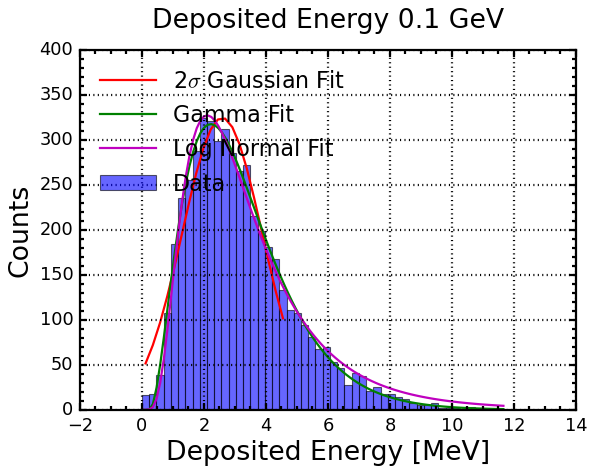

Mean: 8.026947940806714, Peak: 7.465092182159424, RMS: 2.7498648892307163
Initial Gamma Fit Parameters: [np.float64(2132.030365526676), np.float64(2.91903357588317), np.float32(0.0), np.float64(2.7498648892307163)]
Gamma Fit Parameters: [2.12463001e+03 6.89671396e+00 8.88976321e-01 1.03557963e+00]
Gamma Fit Peak: 8.031072832047101 ± 0.052317489114987965, Resolution: 0.33863437604163343 ± 0.006684466353863598
Initial Gaussian Fit Parameters: [335.           0.33863438   6.9954932 ]
Gaussian Fit Peak: 7.437618525922356 ± 0.08854880823887729, Resolution: 0.33024244469430347 ± 0.013356988289625258
Initial Log Normal Fit Parameters: [3.35000000e+02 3.33120362e-01 6.68980683e-01 7.59370630e+00]
Log Normal Fit Parameters: [2.14580431e+03 3.49011776e-01 6.68980683e-04 7.74637782e+00]
Log Normal Fit Peak: 6.858670912897773 ± 0.05384520214403928, Resolution: 0.35988545197657346 ± 0.012776174199615162


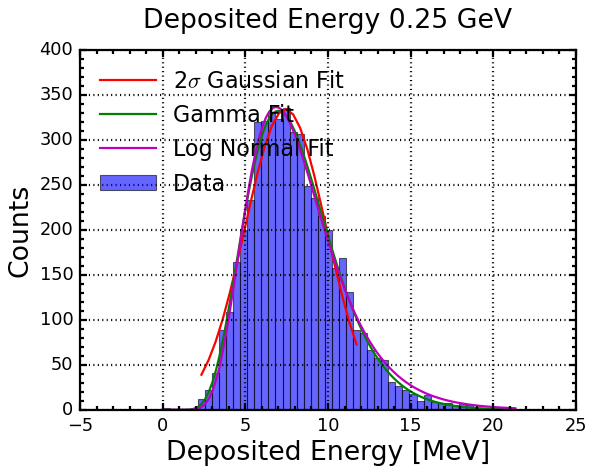

Mean: 16.060198430728914, Peak: 14.388010025024414, RMS: 3.9064391523024775
Initial Gamma Fit Parameters: [np.float64(3081.580102443695), np.float64(3.9778675768306693), np.float32(0.5209008), np.float64(3.9064391523024775)]
Gamma Fit Parameters: [3.06444957e+03 1.69963114e+01 2.53116790e-01 9.28873716e-01]
Gamma Fit Peak: 16.040543738322427 ± 0.07030786472910375, Resolution: 0.2387343592531792 ± 0.0036838312225765534
Initial Gaussian Fit Parameters: [3.37000000e+02 2.38734359e-01 1.51116700e+01]
Gaussian Fit Peak: 15.484642271929925 ± 0.07339639308791991, Resolution: 0.2335196197079579 ± 0.005271177575784955
Initial Log Normal Fit Parameters: [3.37000000e+02 2.39750445e-01 1.00000000e-01 1.56051958e+01]
Log Normal Fit Parameters: [3.08201198e+03 2.43305479e-01 1.00000000e-04 1.58135916e+01]
Log Normal Fit Peak: 14.904735036647002 ± 0.07785568311304863, Resolution: 0.24694954006366676 ± 0.006704475194387779


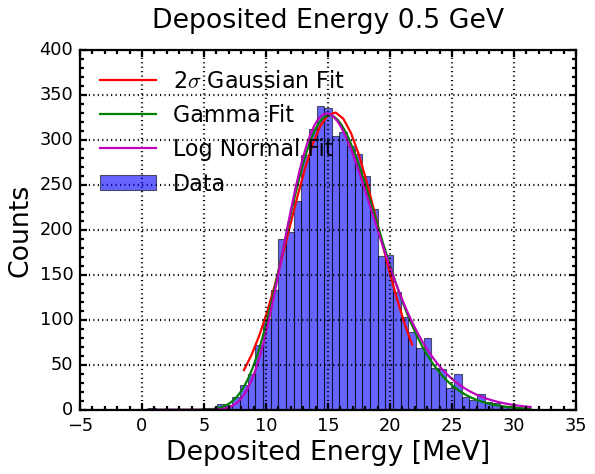

Mean: 32.079250612560394, Peak: 31.23784828186035, RMS: 5.520576008735721
Initial Gamma Fit Parameters: [np.float64(4208.697355270386), np.float64(3.4318943756358333), np.float32(13.133217), np.float64(5.520576008735721)]
Gamma Fit Parameters: [4.18479315e+03 2.88292466e+01 2.91939400e+00 1.01143572e+00]
Gamma Fit Peak: 32.078323671790294 ± 0.11460245585021152, Resolution: 0.16929466297041998 ± 0.0027074667896107266
Initial Gaussian Fit Parameters: [3.30000000e+02 1.69294663e-01 3.10668880e+01]
Gaussian Fit Peak: 31.48959666899723 ± 0.12417547762304829, Resolution: 0.1678045071154146 ± 0.0043318149870775775
Initial Log Normal Fit Parameters: [3.30000000e+02 1.70837692e-01 5.32675120e-01 3.16145249e+01]
Log Normal Fit Parameters: [4.19453706e+03 1.70568188e-01 5.32675120e-04 3.18080558e+01]
Log Normal Fit Peak: 30.896512661503056 ± 0.1157920266853277, Resolution: 0.17181351152519903 ± 0.003500076178440058


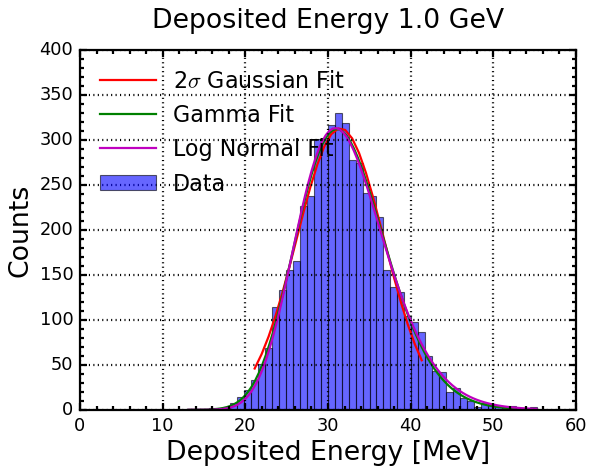

Mean: 64.18438814276931, Peak: 63.290428161621094, RMS: 7.8036253693844975
Initial Gamma Fit Parameters: [np.float64(5907.708297729492), np.float64(2.916748955555546), np.float32(41.423172), np.float64(7.8036253693844975)]
Gamma Fit Parameters: [5.88342166e+03 2.91674896e+01 2.23052707e+01 1.44138777e+00]
Gamma Fit Peak: 64.34693336092258 ± 0.21388696958035064, Resolution: 0.12097691437811832 ± 0.00244671820116587
Initial Gaussian Fit Parameters: [3.37000000e+02 1.20976914e-01 6.29055456e+01]
Gaussian Fit Peak: 63.530247415335474 ± 0.2126542045768479, Resolution: 0.1194367253426 ± 0.003629404467854464
Initial Log Normal Fit Parameters: [3.37000000e+02 1.21135620e-01 5.03352663e-01 6.37151958e+01]
Log Normal Fit Parameters: [5.88796063e+03 1.20945150e-01 5.03352665e-04 6.38574020e+01]
Log Normal Fit Peak: 62.9306151377127 ± 0.20912804551676825, Resolution: 0.12138783890904724 ± 0.0026339544997182225


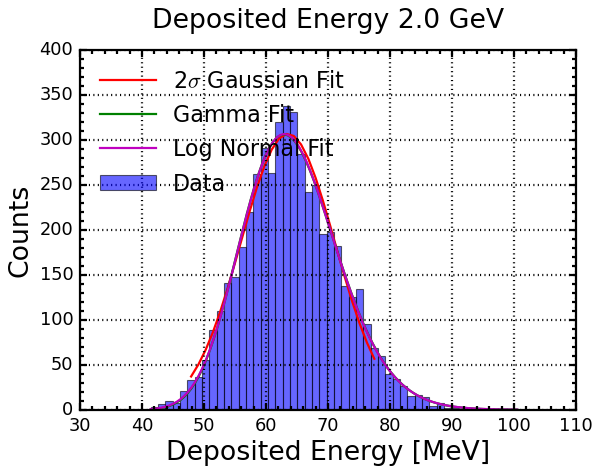

Mean: 160.8706900025635, Peak: 157.467041015625, RMS: 12.372306484566934
Initial Gamma Fit Parameters: [np.float64(9294.824928283691), np.float64(3.355891593507181), np.float32(119.35057), np.float64(12.372306484566934)]
Gamma Fit Parameters: [9.40462934e+03 3.35589159e+01 8.61977819e+01 2.23722202e+00]
Gamma Fit Peak: 161.27652756814507 ± 0.2773991894467207, Resolution: 0.0803603616759006 ± 0.0012245025096369446
Initial Gaussian Fit Parameters: [3.06000000e+02 8.03603617e-02 1.59039306e+02]
Gaussian Fit Peak: 160.1367655492618 ± 0.28017291751052387, Resolution: 0.08073036006469998 ± 0.00193015271162833
Initial Log Normal Fit Parameters: [3.06000000e+02 7.67950310e-02 1.00000000e-01 1.60397023e+02]
Log Normal Fit Parameters: [9.40870254e+03 9.89395609e-02 3.05267811e+01 1.29955614e+02]
Log Normal Fit Peak: 159.21646078696608 ± 0.2750998843840783, Resolution: 0.08039052507191277 ± 0.0012894880150710374


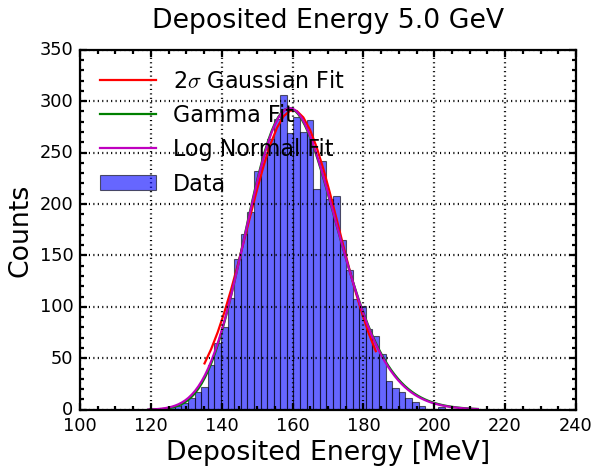

Mean: 322.02867366171654, Peak: 320.4307556152344, RMS: 17.52788874965067
Initial Gamma Fit Parameters: [np.float64(14744.870910644531), np.float64(4.5523357066923875), np.float32(242.23584), np.float64(17.52788874965067)]
Gamma Fit Parameters: [1.46706354e+04 4.55233571e+01 2.06294150e+02 2.56544745e+00]
Gamma Fit Peak: 323.08193054257003 ± 0.3708729989017508, Resolution: 0.05357566799010979 ± 0.0007893314547349575
Initial Gaussian Fit Parameters: [3.46000000e+02 5.35756680e-02 3.20516483e+02]
Gaussian Fit Peak: 321.7322933784726 ± 0.29890278240721996, Resolution: 0.0527920098711743 ± 0.0010101139846292284
Initial Log Normal Fit Parameters: [3.46000000e+02 5.43893418e-02 1.00000000e-01 3.21552713e+02]
Log Normal Fit Parameters: [1.46616154e+04 5.32281355e-02 1.00000071e-04 3.22017167e+02]
Log Normal Fit Peak: 321.10620780226054 ± 0.32161377861907275, Resolution: 0.05326584314668002 ± 0.0006687708255485538


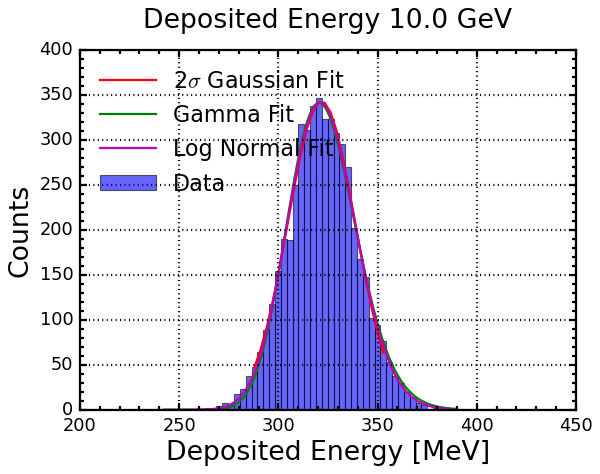

Mean: 643.4845792038905, Peak: 641.5952758789062, RMS: 24.963060829520618
Initial Gamma Fit Parameters: [np.float64(17828.7431640625), np.float64(3.5781124512012914), np.float32(554.16394), np.float64(24.963060829520618)]
Gamma Fit Parameters: [1.77567511e+04 3.57811245e+01 4.96212730e+02 4.16189198e+00]
Gamma Fit Peak: 645.1299052829081 ± 0.5808880932063374, Resolution: 0.03858963070964779 ± 0.0006256346669670972
Initial Gaussian Fit Parameters: [3.09000000e+02 3.85896307e-02 6.40968013e+02]
Gaussian Fit Peak: 642.950073904576 ± 0.4030958155144184, Resolution: 0.03797286249068218 ± 0.0006751524661609837
Initial Log Normal Fit Parameters: [3.09000000e+02 3.87789814e-02 1.00000000e-01 6.43000922e+02]
Log Normal Fit Parameters: [1.77366074e+04 3.81608260e-02 1.00009992e-04 6.43252094e+02]
Log Normal Fit Peak: 642.3161407361835 ± 0.47262013103769734, Resolution: 0.038174717157245464 ± 0.00047859650866662246


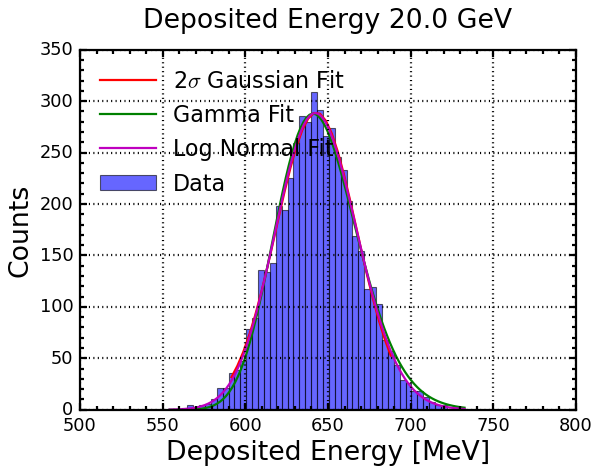

Mean: 965.8084563323089, Peak: 972.860107421875, RMS: 31.52751889040098
Initial Gamma Fit Parameters: [np.float64(28771.553649902344), np.float64(5.348697110914899), np.float32(797.1773), np.float64(31.52751889040098)]
Gamma Fit Parameters: [2.86493231e+04 5.34869711e+01 7.40081021e+02 4.26007448e+00]
Gamma Fit Peak: 967.9395013788087 ± 0.5524776015778979, Resolution: 0.0321879249950024 ± 0.0003854428323549611
Initial Gaussian Fit Parameters: [3.71000000e+02 3.21879250e-02 9.63679427e+02]
Gaussian Fit Peak: 965.8232745996877 ± 0.35631955051688485, Resolution: 0.031824331543325486 ± 0.00039547810310093626
Initial Log Normal Fit Parameters: [3.71000000e+02 3.26349646e-02 8.59335755e+00 9.65294280e+02]
Log Normal Fit Parameters: [2.86426620e+04 3.19761137e-02 8.59348320e-03 9.66033308e+02]
Log Normal Fit Peak: 965.0546643525361 ± 0.4055043810310729, Resolution: 0.03198400478403471 ± 0.0002692095660247943


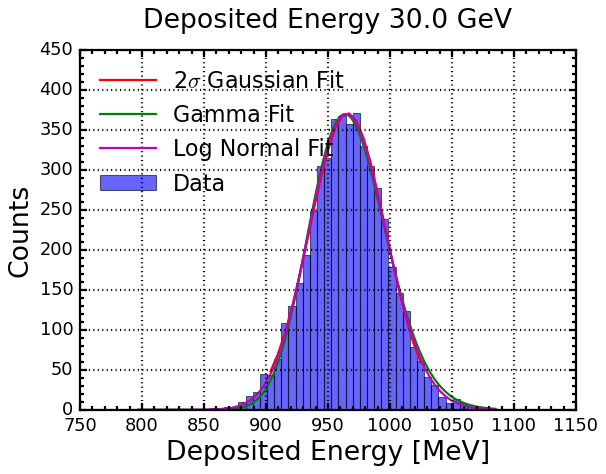

Mean: 1287.189030414064, Peak: 1278.019287109375, RMS: 36.19514805641707
Initial Gamma Fit Parameters: [np.float64(29707.496704101562), np.float64(4.445120350173617), np.float32(1126.2972), np.float64(36.19514805641707)]
Gamma Fit Parameters: [2.96813520e+04 4.44512035e+01 1.04818033e+03 5.43883815e+00]
Gamma Fit Peak: 1289.9432363731921 ± 0.8473702241318286, Resolution: 0.028111064894612826 ± 0.00044778222953992497
Initial Gaussian Fit Parameters: [3.33000000e+02 2.81110649e-02 1.28450440e+03]
Gaussian Fit Peak: 1287.246205394737 ± 0.6786564377120913, Resolution: 0.027879848414451472 ± 0.0005642837724040868
Initial Log Normal Fit Parameters: [3.33000000e+02 2.81139719e-02 1.00000000e-01 1.28668044e+03]
Log Normal Fit Parameters: [2.96842208e+04 2.79038090e-02 1.01498982e-04 1.28747631e+03]
Log Normal Fit Peak: 1286.474344385579 ± 0.7331512951970467, Resolution: 0.02790923933080648 ± 0.0003684927378687447


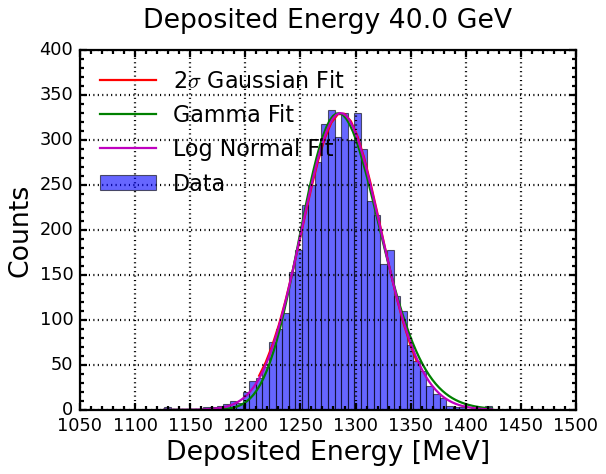

Mean: 1609.6083587078745, Peak: 1602.6357421875, RMS: 40.672260028937934
Initial Gamma Fit Parameters: [np.float64(34703.14099121094), np.float64(4.865192593141759), np.float32(1411.73), np.float64(40.672260028937934)]
Gamma Fit Parameters: [3.45403955e+04 4.86519259e+01 1.33258844e+03 5.75073853e+00]
Gamma Fit Peak: 1612.3729407069618 ± 0.9878345564923323, Resolution: 0.02487758042774386 ± 0.0004148119115333954
Initial Gaussian Fit Parameters: [3.79000000e+02 2.48775804e-02 1.60662220e+03]
Gaussian Fit Peak: 1609.4201661906998 ± 0.8490625799232295, Resolution: 0.02466701121803327 ± 0.0005716020702332368
Initial Log Normal Fit Parameters: [3.79000000e+02 2.52643880e-02 1.00000000e-01 1.60909474e+03]
Log Normal Fit Parameters: [3.45351219e+04 2.46941173e-02 1.00002120e-04 1.60972464e+03]
Log Normal Fit Peak: 1608.7434325752733 ± 0.8733635115582052, Resolution: 0.024697880887051812 ± 0.00034922728600170466


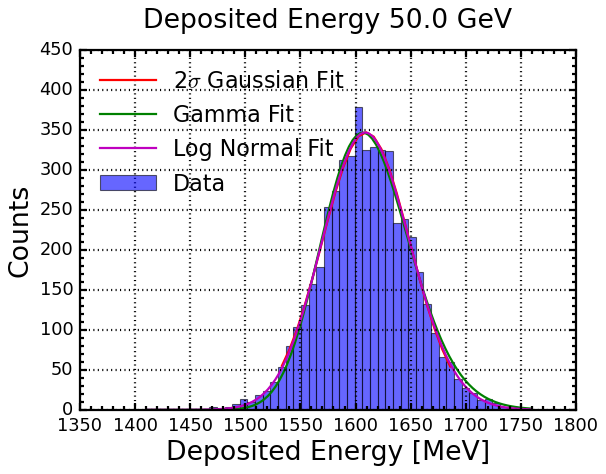

Mean: 1930.2794144730667, Peak: 1923.452880859375, RMS: 45.20093994912141
Initial Gamma Fit Parameters: [np.float64(42148.36120605469), np.float64(5.098065963159707), np.float32(1699.842), np.float64(45.20093994912141)]
Gamma Fit Parameters: [4.20515133e+04 5.09806596e+01 1.61291870e+03 6.29298858e+00]
Gamma Fit Peak: 1933.7394063090576 ± 1.0477842454177257, Resolution: 0.023236018914311377 ± 0.0003657639268138712
Initial Gaussian Fit Parameters: [3.79000000e+02 2.32360189e-02 1.92744642e+03]
Gaussian Fit Peak: 1930.5436878659086 ± 0.8896623717064237, Resolution: 0.02306386265986207 ± 0.0004917886385263747
Initial Log Normal Fit Parameters: [3.79000000e+02 2.34135768e-02 1.00000000e-01 1.92975040e+03]
Log Normal Fit Parameters: [4.20679818e+04 2.30914855e-02 1.31919951e-04 1.93084743e+03]
Log Normal Fit Peak: 1929.818277497254 ± 0.9008474333731138, Resolution: 0.023094562463596147 ± 0.0003000695338351866


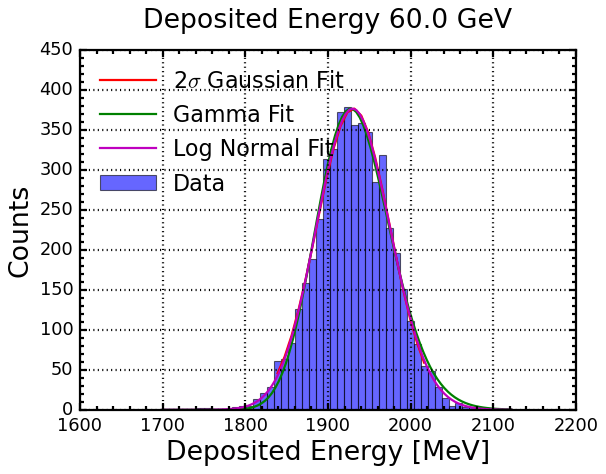

In [43]:
#Fit Sum of E and Save as CSV
results = []
for i_E in range(len(ParticleEnergy)):
    hist = hist_E[i_E]
    (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(hist['Energy'],"E", hist['bin_edges'], hist['counts'])
    results.append({
        "ParticleEnergy": ParticleEnergy[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath, f"Reco_Results/SumE_Fit_Threshold{Threshold_i}.csv")
df.to_csv(outputfile_name, index=False)



In [44]:
# def plot_binned(x, y, num_bins=30, color="blue", label=None):
#     """Plot mean y in bins of x."""
#     bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
#     plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)
# def exp_func(x, a, b, c):
#     return a * np.exp(b * x) + c
# def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
#     #Step 1: Linear
#     linear_range = (10,60)
#     mask_lin = (x > linear_range[0]) & (x < linear_range[1])
#     coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
#     y_lin = np.poly1d(coeffs_lin)(x)
#     residual = y - y_lin
#     print("Step 1 Linear fit coeffs:", coeffs_lin)
    
#     if plot:
#         plt.figure(figsize=(5,4))
#         plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
#         plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
#         plt.xlabel("x")
#         plt.ylabel("y")
#         plt.title("Step 1: Linear Fit")
#         plt.grid(True, linestyle="--", alpha=0.5)
#         plt.show()
    
#     # Step 2: exp fit
#     #residual = y
#     fit_range = (0, 3)
#     mask_fit = (x > fit_range[0]) & (x < fit_range[1])
#     def fit_func2(x, a, b, c):
#         return a * np.exp(b * x) + c
#     coeff_exp1, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
#     x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
#     y_fit2 = fit_func2(x_fit2, *coeff_exp1)
#     if plot:
#         plt.figure(figsize=(5,4))
#         plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
#         plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
#         plt.xlabel("x")
#         plt.ylabel("Residual")
#         plt.title("Step 2: exp Fit Residual")
#         plt.grid(True, linestyle="--", alpha=0.5)
#         plt.show()

#     residual = y - fit_func2(x, *coeff_exp1)

#     # Step 4: Linear again
#     mask_fit = (x > fit_range[0]) & (x < fit_range[1])
#     params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
#     y_lin2 = np.poly1d(params_lin2)(x)
#     print("Step 3 Linear fit coeffs:", params_lin2)
    
#     if plot:
#         plt.figure(figsize=(5,4))
#         plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
#         plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
#         plt.xlabel("x")
#         plt.ylabel("Residual")
#         plt.title("Step 3: Linear Fit Residual")
#         plt.grid(True, linestyle="--", alpha=0.5)
#         plt.show()
    
#     # Final combined function
#     def f(x_val):
#         return ( 
#                 fit_func2(x_val, *coeff_exp1) + 
#                 #fit_func3(x_val, *coeff_fit3) + 
#                 np.poly1d(params_lin2)(x_val))
#     def f_inv(y_val):
#         a, b, c = coeff_exp1
#         m, d = params_lin2
#         term = (a * b / m) * np.exp(b * (y_val - (c + d)) / m)
#         return (y_val - (c + d)) / m - (1.0 / b) * lambertw(term).real
#     return f, f_inv

# E_calib_fit, E_calib_fit_inv = Combined_fit(E_true, N_hits, fit_range=(0,65), plot=True, num_bins=200)
# x_fit = np.linspace(0, 65, 200)
# y_fit = E_calib_fit(x_fit)
# plt.figure(figsize=fig_size)
# plot_binned(E_true, N_hits, color="blue", label="Number of hits", num_bins=100)
# plt.plot(x_fit, y_fit, color="red", linestyle="-", label="Combined Fit")
# plt.xlabel("E_truth [GeV]")
# plt.ylabel("Number of hits")
# plt.title("Number of hits vs True Energy")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(loc="upper left")  
# plt.show()

# N_hits_calib = E_calib_fit_inv(N_hits)

hist_N = []
for i_E in range(len(ParticleEnergy)):
    #Number of hits
    mask = E_true == ParticleEnergy[i_E]
    N_bins = min(50, (N_hits[mask].max()-N_hits[mask].min()-1))
    counts, bin_edges = ConstructHists(N_hits[mask], Nbins=N_bins)
    hist = {
        'counts': counts,
        'bin_edges': bin_edges,
        'Energy': ParticleEnergy[i_E]
        }
    hist_N.append(hist)

Mean: 4.961357142857143, Peak: 4.821428571428571, RMS: 2.1184892082590845
Initial Gamma Fit Parameters: [np.float64(5357.142857142857), np.float64(2.341931751889474), np.float64(0.0), np.float64(2.1184892082590845)]
Gamma Fit Parameters: [ 5.32495854e+03  1.09948737e+01 -1.92572150e+00  6.24895462e-01]
Gamma Fit Peak: 4.944925214552284 ± 0.026274017790538548, Resolution: 0.41902773224685147 ± 0.0053349294239349405
Initial Gaussian Fit Parameters: [1.04500000e+03 4.19027732e-01 4.32002975e+00]
Gaussian Fit Peak: 4.542990705667295 ± 0.09155554940662199, Resolution: 0.4198512929188998 ± 0.024812766517159066
Initial Log Normal Fit Parameters: [1.04500000e+03 4.09248975e-01 9.62258182e-01 4.56280223e+00]
Log Normal Fit Parameters: [5.39123397e+03 4.45704347e-01 9.62258182e-04 4.88658453e+00]
Log Normal Fit Peak: 4.00715453861048 ± 0.13061293517674474, Resolution: 0.4686998158456492 ± 0.06674780219840162


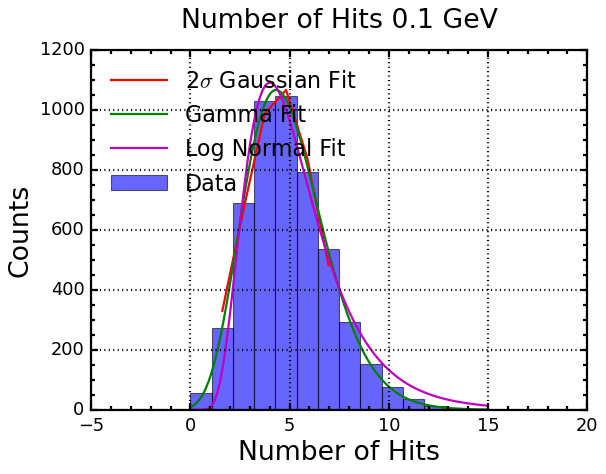

Mean: 11.436227272727274, Peak: 10.977272727272727, RMS: 3.126919242376929
Initial Gamma Fit Parameters: [np.float64(5227.272727272727), np.float64(3.65734654024324), np.float64(0.0), np.float64(3.126919242376929)]
Gamma Fit Parameters: [ 5.21070301e+03  2.85915890e+01 -5.12367977e+00  5.79380713e-01]
Gamma Fit Peak: 11.441735427753182 ± 0.06495231832251687, Resolution: 0.2707642228054325 ± 0.004595831564728334
Initial Gaussian Fit Parameters: [6.97000000e+02 2.70764223e-01 1.08623547e+01]
Gaussian Fit Peak: 11.098597092805619 ± 0.07577408398531893, Resolution: 0.27145917050267204 ± 0.007774912847248802
Initial Log Normal Fit Parameters: [6.97000000e+02 2.68509102e-01 7.13295167e-01 1.10313098e+01]
Log Normal Fit Parameters: [5.23441981e+03 2.77549563e-01 7.13295167e-04 1.13779849e+01]
Log Normal Fit Peak: 10.535118410327764 ± 0.11890229156829521, Resolution: 0.28296444782196173 ± 0.015113944758772431


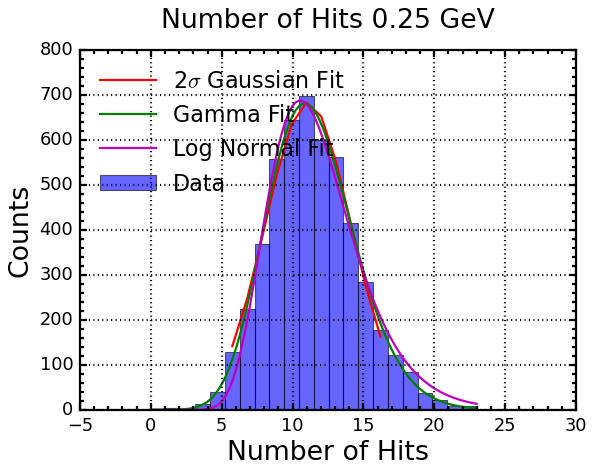

Mean: 20.279967567567564, Peak: 18.972972972972972, RMS: 4.310564600489017
Initial Gamma Fit Parameters: [np.float64(5135.135135135136), np.float64(4.472724423473511), np.float64(1.0), np.float64(4.310564600489017)]
Gamma Fit Parameters: [ 5.13085891e+03  4.29699964e+01 -7.71484724e+00  6.51826907e-01]
Gamma Fit Peak: 20.29415261066939 ± 0.07379236151757529, Resolution: 0.2105445579430739 ± 0.00273105558006958
Initial Gaussian Fit Parameters: [4.85000000e+02 2.10544558e-01 1.96423257e+01]
Gaussian Fit Peak: 19.930106387437675 ± 0.09157882026349322, Resolution: 0.21126927413404284 ± 0.005108919466409062
Initial Log Normal Fit Parameters: [4.85000000e+02 2.10209141e-01 1.00000000e-01 1.98368167e+01]
Log Normal Fit Parameters: [5.14734382e+03 2.13955377e-01 1.00000000e-04 2.01995660e+01]
Log Normal Fit Peak: 19.295837512022903 ± 0.106320729749099, Resolution: 0.2164263958270164 ± 0.00620969166572367


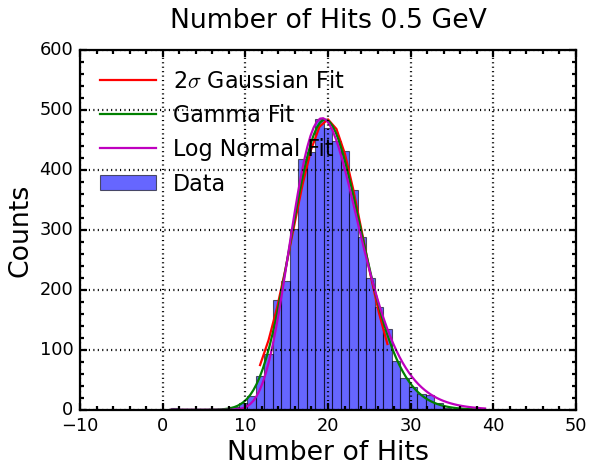

Mean: 35.35540909090909, Peak: 36.03409090909091, RMS: 5.891693399493592
Initial Gamma Fit Parameters: [np.float64(5113.636363636367), np.float64(3.964124998920778), np.float64(12.0), np.float64(5.891693399493592)]
Gamma Fit Parameters: [ 5.13185051e+03  3.96412500e+01 -2.25040063e+00  9.54091788e-01]
Gamma Fit Peak: 35.57099042914786 ± 0.12183171783357029, Resolution: 0.16887597532368348 ± 0.002523280390362147
Initial Gaussian Fit Parameters: [3.48000000e+02 1.68875975e-01 3.46168986e+01]
Gaussian Fit Peak: 35.06750460061534 ± 0.11660559058401683, Resolution: 0.16961056820879175 ± 0.0036718297211288773
Initial Log Normal Fit Parameters: [3.48000000e+02 1.65502115e-01 2.10187209e+00 3.48745006e+01]
Log Normal Fit Parameters: [5.13419346e+03 1.69969294e-01 2.10187209e-03 3.53461740e+01]
Log Normal Fit Peak: 34.34174948196231 ± 0.14457485442251605, Resolution: 0.17119426536895832 ± 0.003777392424314165


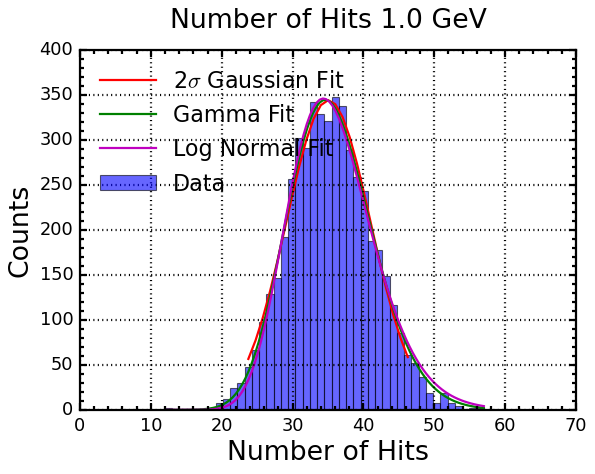

Mean: 61.199344, Peak: 64.53999999999999, RMS: 7.652294540179697
Initial Gamma Fit Parameters: [np.float64(5399.999999999992), np.float64(3.162364421930855), np.float64(37.0), np.float64(7.652294540179697)]
Gamma Fit Parameters: [5.41688489e+03 3.16236442e+01 1.78489894e+01 1.38455889e+00]
Gamma Fit Peak: 61.63378700862714 ± 0.7066555163742951, Resolution: 0.1263276845190348 ± 0.008402583682589242
Initial Gaussian Fit Parameters: [4.69000000e+02 1.26327685e-01 6.02492281e+01]
Gaussian Fit Peak: 60.878105320486036 ± 0.5609416156779398, Resolution: 0.12252491812772895 ± 0.009854205612950091
Initial Log Normal Fit Parameters: [4.69000000e+02 1.24554192e-01 4.74836009e+00 6.07264648e+01]
Log Normal Fit Parameters: [5.40767400e+03 1.25845473e-01 4.74836025e-03 6.11857739e+01]
Log Normal Fit Peak: 60.22915080956882 ± 0.6938216328188557, Resolution: 0.12633565002982716 ± 0.008672030590862318


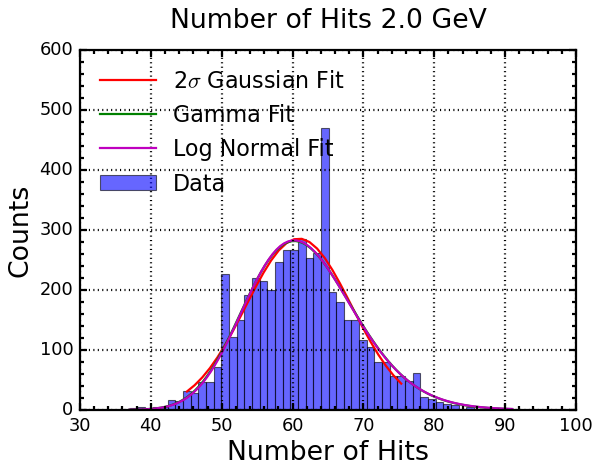

Mean: 125.52908000000001, Peak: 127.43, RMS: 11.078968801905708
Initial Gamma Fit Parameters: [np.float64(9299.999999999996), np.float64(4.1095052088393365), np.float64(80.0), np.float64(11.078968801905708)]
Gamma Fit Parameters: [9.28815670e+03 4.10950521e+01 5.51594512e+01 1.72820546e+00]
Gamma Fit Peak: 126.18014459410043 ± 0.8039973760676773, Resolution: 0.08780093074251849 ± 0.0044814012861901405
Initial Gaussian Fit Parameters: [3.92000000e+02 8.78009307e-02 1.24451939e+02]
Gaussian Fit Peak: 125.25324229295006 ± 0.7293827731097504, Resolution: 0.08609193365392274 ± 0.006245092385595122
Initial Log Normal Fit Parameters: [3.92000000e+02 8.80870347e-02 3.35348195e+00 1.25043013e+02]
Log Normal Fit Parameters: [9.27683334e+03 8.73314601e-02 3.35348204e-03 1.25553655e+02]
Log Normal Fit Peak: 124.60307998236675 ± 0.7880205702315073, Resolution: 0.0874959114233342 ± 0.004456213278769932


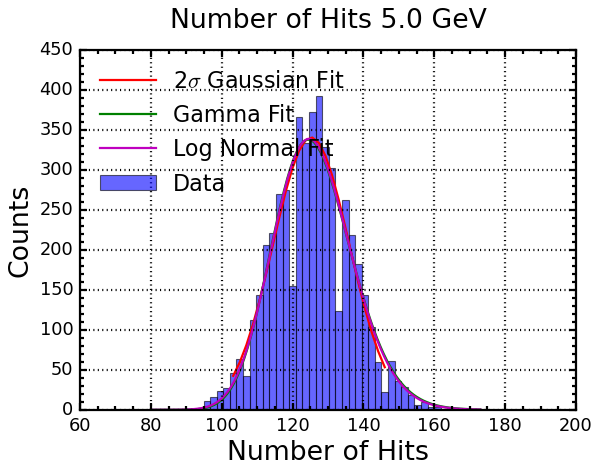

Mean: 211.60064, Peak: 212.0, RMS: 14.527814962698278
Initial Gamma Fit Parameters: [np.float64(12000.00000000003), np.float64(4.5155200674317975), np.float64(146.0), np.float64(14.527814962698278)]
Gamma Fit Parameters: [1.20378657e+04 4.51552007e+01 1.13228927e+02 2.19491041e+00]
Gamma Fit Peak: 212.3405468889797 ± 1.0968773834811973, Resolution: 0.06946047614423596 ± 0.0035779193719758977
Initial Gaussian Fit Parameters: [4.56000000e+02 6.94604761e-02 2.10145636e+02]
Gaussian Fit Peak: 211.18791921264045 ± 1.036646600404121, Resolution: 0.06936014840627422 ± 0.00538176092411831
Initial Log Normal Fit Parameters: [4.56000000e+02 6.85760611e-02 1.88674175e+00 2.11103680e+02]
Log Normal Fit Parameters: [1.20313080e+04 6.91275123e-02 1.88674207e-03 2.11498308e+02]
Log Normal Fit Peak: 210.49193701842725 ± 1.0797320214916426, Resolution: 0.0692095620116089 ± 0.003508504874046007


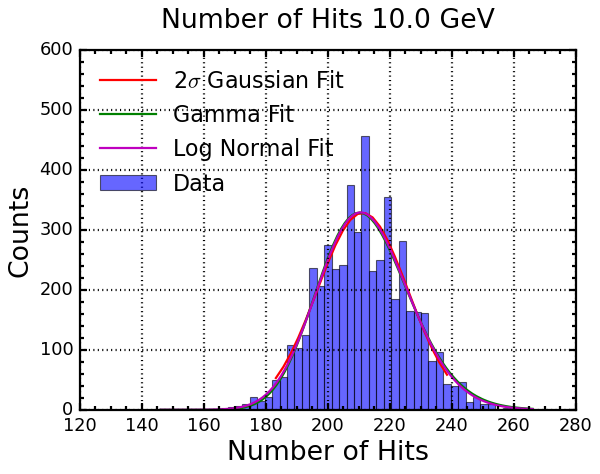

Mean: 347.222826565313, Peak: 344.65, RMS: 18.932909763862284
Initial Gamma Fit Parameters: [np.float64(13697.260000000046), np.float64(3.3921265862628647), np.float64(283.0), np.float64(18.932909763862284)]
Gamma Fit Parameters: [1.37746722e+04 3.39212658e+01 2.35296889e+02 3.32843051e+00]
Gamma Fit Peak: 348.2014652726221 ± 1.2384745082938076, Resolution: 0.05567303861343904 ± 0.00250060317388818
Initial Gaussian Fit Parameters: [3.22000000e+02 5.56730386e-02 3.44873035e+02]
Gaussian Fit Peak: 346.522598718267 ± 1.0720202033584907, Resolution: 0.05539834921359644 ± 0.0033643126362801635
Initial Log Normal Fit Parameters: [3.22000000e+02 5.44862212e-02 1.00000000e-01 3.46707800e+02]
Log Normal Fit Parameters: [1.37661474e+04 5.52100576e-02 1.00003038e-04 3.46825527e+02]
Log Normal Fit Peak: 345.77006002458376 ± 1.213013589774329, Resolution: 0.055252140571468586 ± 0.0023543526519431302


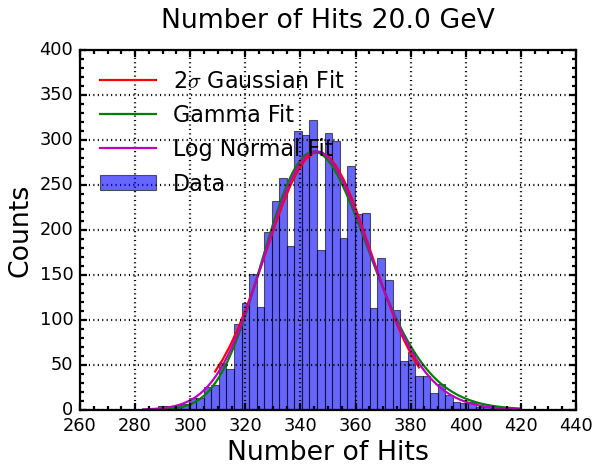

Mean: 460.3732679607765, Peak: 452.02, RMS: 22.22969143770757
Initial Gamma Fit Parameters: [np.float64(20187.880000000103), np.float64(5.010113085594041), np.float64(349.0), np.float64(22.22969143770757)]
Gamma Fit Parameters: [2.00750754e+04 5.01011309e+01 3.08313942e+02 3.05680835e+00]
Gamma Fit Peak: 461.4634968182496 ± 0.7285324830266531, Resolution: 0.046887234939648866 ± 0.0010762848413743648
Initial Gaussian Fit Parameters: [4.48000000e+02 4.68872349e-02 4.58406688e+02]
Gaussian Fit Peak: 459.86230890628525 ± 0.7124909714794532, Resolution: 0.046561240202018545 ± 0.0016572283133197885
Initial Log Normal Fit Parameters: [4.48000000e+02 4.82581241e-02 1.00000000e-01 4.59837511e+02]
Log Normal Fit Parameters: [2.00761660e+04 4.66734440e-02 1.07018024e-04 4.60178685e+02]
Log Normal Fit Peak: 459.1774248688456 ± 0.7070746499427187, Resolution: 0.04669886314203304 ± 0.0010305321468959904


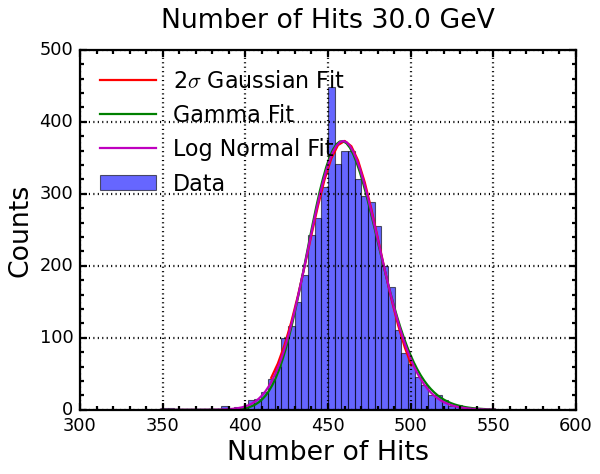

Mean: 559.7370390390391, Peak: 566.93, RMS: 24.222057094957655
Initial Gamma Fit Parameters: [np.float64(21278.699999999953), np.float64(5.067160008659608), np.float64(437.0), np.float64(24.222057094957655)]
Gamma Fit Parameters: [2.12923808e+04 5.06716001e+01 3.88532002e+02 3.40370396e+00]
Gamma Fit Peak: 561.0031280153931 ± 0.8664661317354738, Resolution: 0.04318856816858718 ± 0.0010504934653813788
Initial Gaussian Fit Parameters: [3.80000000e+02 4.31885682e-02 5.57599424e+02]
Gaussian Fit Peak: 559.245854689656 ± 0.7740023708041228, Resolution: 0.04285913796165828 ± 0.0014892457908870147
Initial Log Normal Fit Parameters: [3.80000000e+02 4.32537551e-02 8.76156632e+00 5.59213681e+02]
Log Normal Fit Parameters: [2.12600683e+04 4.28163027e-02 8.76176950e-03 5.59552591e+02]
Log Normal Fit Peak: 558.5365009184114 ± 0.8115296523743509, Resolution: 0.04283526320073589 ± 0.0009365769963865932


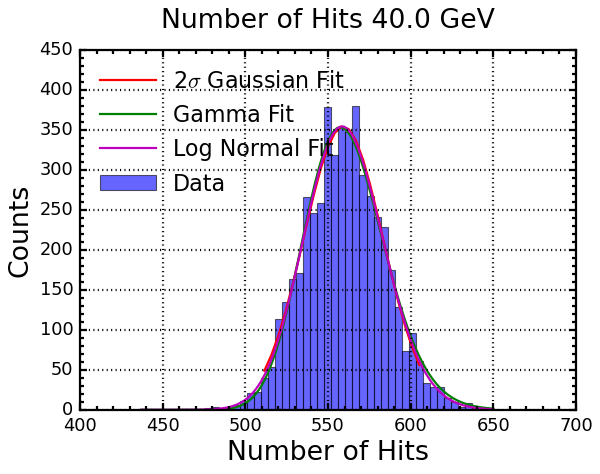

Mean: 650.6070750750752, Peak: 654.22, RMS: 26.935400119786276
Initial Gamma Fit Parameters: [np.float64(24575.399999999794), np.float64(5.071655682394188), np.float64(514.0), np.float64(26.935400119786276)]
Gamma Fit Parameters: [2.44758238e+04 5.07165568e+01 4.64170739e+02 3.71731336e+00]
Gamma Fit Peak: 652.700073504375 ± 0.7206888910946839, Resolution: 0.040559294485885064 ± 0.0007503261363232844
Initial Gaussian Fit Parameters: [3.94000000e+02 4.05592945e-02 6.48982760e+02]
Gaussian Fit Peak: 650.7867862377695 ± 0.5875265261193113, Resolution: 0.03993772955519581 ± 0.000983514197376586
Initial Log Normal Fit Parameters: [3.94000000e+02 4.13826871e-02 5.28205326e+00 6.50050222e+02]
Log Normal Fit Parameters: [2.44447503e+04 4.02021310e-02 5.28205519e-03 6.51091943e+02]
Log Normal Fit Peak: 650.0457729204052 ± 0.6164433321072916, Resolution: 0.040218054260899055 ± 0.0006140867263585338


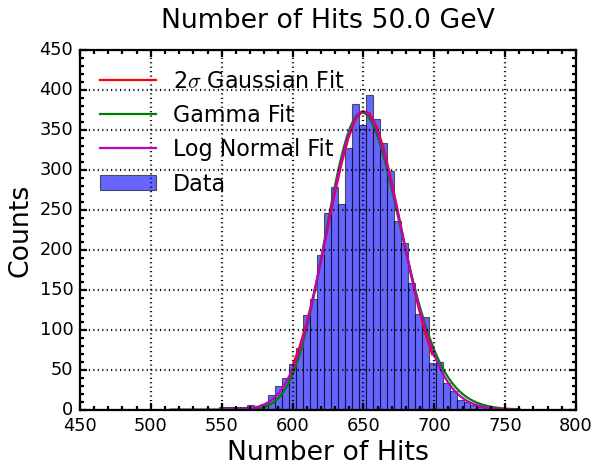

Mean: 733.5718838838839, Peak: 733.72, RMS: 28.411040035000504
Initial Gamma Fit Parameters: [np.float64(27172.800000000272), np.float64(4.877395678340974), np.float64(595.0), np.float64(28.411040035000504)]
Gamma Fit Parameters: [2.70679823e+04 4.87739568e+01 5.41568689e+02 3.98914552e+00]
Gamma Fit Peak: 736.1350996125536 ± 1.0330658016792527, Resolution: 0.03784568300909919 ± 0.0009549113064113131
Initial Gaussian Fit Parameters: [4.37000000e+02 3.78456830e-02 7.32145954e+02]
Gaussian Fit Peak: 734.1794845256081 ± 0.96214764907549, Resolution: 0.037533098053075316 ± 0.0014330915572754064
Initial Log Normal Fit Parameters: [4.37000000e+02 3.87152169e-02 1.79555461e+00 7.33022326e+02]
Log Normal Fit Parameters: [2.70438903e+04 3.75103728e-02 1.79555523e-03 7.34403459e+02]
Log Normal Fit Peak: 733.3726550944266 ± 0.9352127865895529, Resolution: 0.0375234794809018 ± 0.0008274054220299555


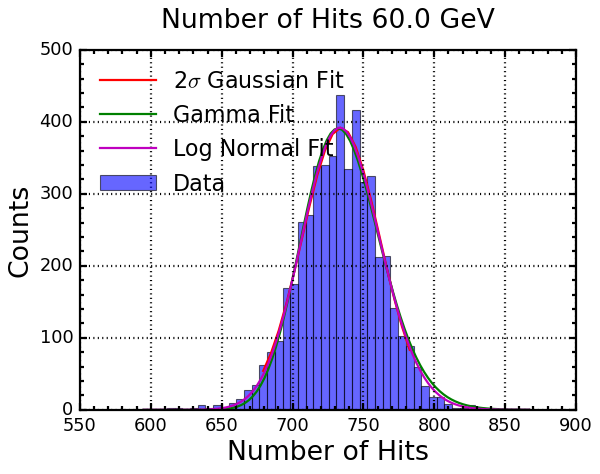

In [45]:
results = []
for i_E in range(len(ParticleEnergy)):
    hist = hist_N[i_E]
    (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(hist['Energy'],"N", hist['bin_edges'], hist['counts'])

    results.append({
        "ParticleEnergy": ParticleEnergy[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath, f"Reco_Results/NHits_Fit_Threshold{Threshold_i}.csv")
df.to_csv(outputfile_name, index=False)

